In [ ]:
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 328M/331M [00:02<00:00, 172MB/s]
100% 331M/331M [00:02<00:00, 142MB/s]


In [ ]:
!unzip utkface-new.zip


Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

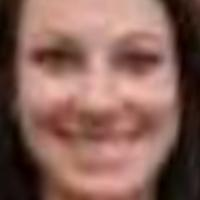

26 1


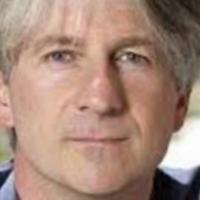

50 0


In [ ]:
import os
from PIL import Image
import pandas as pd

images = []
ages = []
genders = []

for i in os.listdir('/content/crop_part1/'):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('/content/crop_part1/' + i))

images = pd.Series(list(images), name='Images')
ages = pd.Series(list(ages), name='Ages')
genders = pd.Series(list(genders), name='Genders')

df = pd.concat([images, ages, genders], axis=1)
df

display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

#Pre processing (removing the extreme ages And resizing to 128*128)


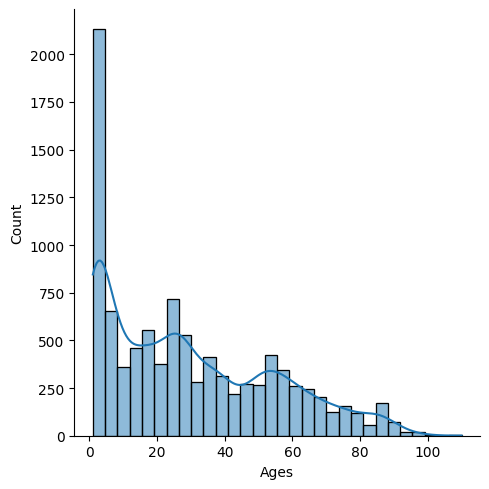

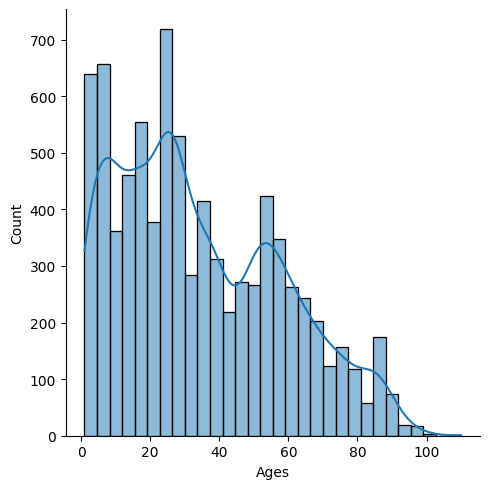

In [ ]:
import matplotlib.pyplot as plt


# Plot initial age distribution
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Filter and sample data for ages <= 4
under4s = df[df['Ages'] <= 4].sample(frac=0.3)
df = pd.concat([df[df['Ages'] > 4], under4s], ignore_index=True)

# Plot age distribution after filtering
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Remove ages > 80
df = df[df['Ages'] < 80]

# Remove entries with gender = 3
df = df[df['Genders'] != 3]


# Resize images and prepare data for training
x = []
y = []

for i in range(len(df)):
    resized_image = df['Images'].iloc[i].resize((200, 200), Image.LANCZOS).copy()
    ar = np.asarray(resized_image)
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)


In [ ]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)



In [ ]:
from tensorflow.keras import layers

# Age Model
age_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

age_model.add(resnet_model)
age_model.add(GlobalAveragePooling2D())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(64, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['mae'])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=16)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=16)

history_age = age_model.fit(train_age, epochs=20, shuffle=True, validation_data=test_age)

Epoch 1/20
394/394 [==============================] - 155s 276ms/step - loss: 394.2274 - mae: 14.3677 - val_loss: 1013.4713 - val_mae: 24.9915
Epoch 2/20
394/394 [==============================] - 104s 264ms/step - loss: 216.1435 - mae: 10.7724 - val_loss: 437.6334 - val_mae: 16.4504
Epoch 3/20
394/394 [==============================] - 101s 257ms/step - loss: 191.1903 - mae: 10.0487 - val_loss: 211.4941 - val_mae: 10.9875
Epoch 4/20
394/394 [==============================] - 97s 245ms/step - loss: 174.5447 - mae: 9.6199 - val_loss: 111.3034 - val_mae: 7.4589
Epoch 5/20
394/394 [==============================] - 98s 249ms/step - loss: 159.1748 - mae: 9.0805 - val_loss: 76.3547 - val_mae: 6.3126
Epoch 6/20
394/394 [==============================] - 98s 247ms/step - loss: 145.6467 - mae: 8.7019 - val_loss: 73.5507 - val_mae: 6.1787
Epoch 7/20
394/394 [==============================] - 97s 246ms/step - loss: 134.1644 - mae: 8.2854 - val_loss: 64.3061 - val_mae: 5.7305
Epoch 8/20
394/394 [

In [ ]:
age_model.save('age_model_resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
final_training_accuracy_age = history_age.history.get('mean_squared_error', history_age.history.get('mae'))
final_validation_accuracy_age = history_age.history.get('mean_squared_error', history_age.history.get('val_mae'))
print(final_training_accuracy_age)
print(final_validation_accuracy_age)

[14.367698669433594, 10.772397994995117, 10.048734664916992, 9.61994743347168, 9.080543518066406, 8.701879501342773, 8.285355567932129, 8.248200416564941, 8.060914993286133, 8.043333053588867, 7.795008182525635, 7.755121231079102, 7.666822910308838, 7.520303726196289, 7.4474053382873535, 7.483861923217773, 7.255154609680176, 7.158838272094727, 7.270112991333008, 7.4803547859191895]
[24.991504669189453, 16.45035171508789, 10.987540245056152, 7.458856582641602, 6.312635898590088, 6.178661346435547, 5.730461120605469, 7.639109134674072, 6.4055705070495605, 7.382997989654541, 6.875890254974365, 6.7952728271484375, 6.539885997772217, 8.442731857299805, 5.868759632110596, 8.606608390808105, 5.45942497253418, 5.937792778015137, 6.077098846435547, 6.108029365539551]


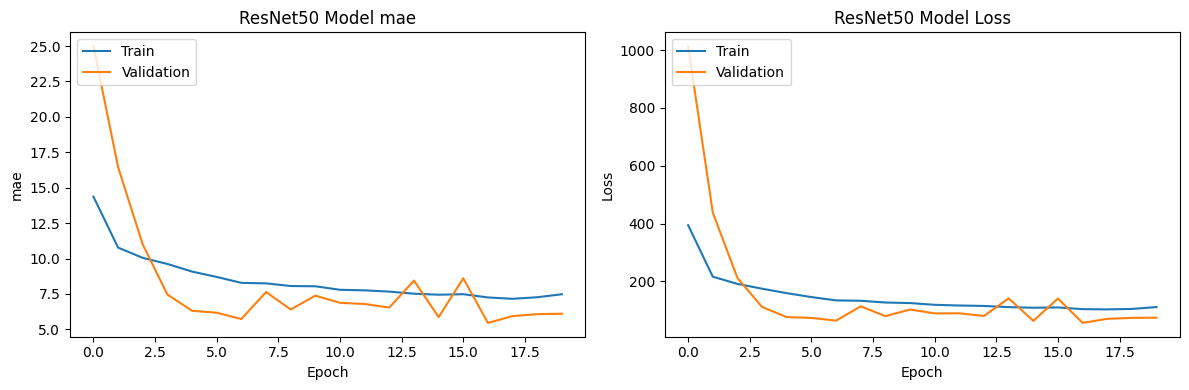

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title(f'{model_name} Model mae')
    plt.xlabel('Epoch')
    plt.ylabel('mae')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


plot_history(history_age, 'ResNet50')

In [ ]:
def process_and_predict_resnet50(file, age_model):
    im = Image.open(file)
    im = im.resize((200, 200), Image.ANTIALIAS)
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = age_model.predict(ar)
    print('Age:', int(age))
    return im.resize((300, 300), Image.ANTIALIAS)

In [ ]:
pred=age_model.predict(x_test_age[200].resize((300, 300)))

NameError: name 'age_model' is not defined

In [ ]:
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow as tf

In [ ]:
agemodel = load_model('/content/drive/MyDrive/VGG19model_pretrain.h5')

In [ ]:
def predict_age(image):
    # Convert the image to a PIL image
    image = Image.fromarray(image)
    # Resize the image to the input shape required by the model
    image = image.resize((128, 128))
    # Convert the image to a numpy array and normalize it
    image_array = np.array(image) / 255.0
    # Reshape the image to match the model's input shape
    image_array = image_array.reshape(-1, 128, 128, 3)
    # Predict the age using the model
    age = agemodel.predict(image_array)
    age_pred = tf.round(age).numpy()[0][0]
    return f"Predicted Age: {int(age_pred)}"

In [ ]:
iface = gr.Interface(
    fn=predict_age,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    title="Age Prediction",
    description="Upload an image of a person to predict their age."
)

In [ ]:
iface.launch()


Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://61a1ef7f90b45497df.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
